In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pretrainedmodels
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### This model will be trained using a convolutional neural network, implemented using pytorch (if all goes well...)

I have decided to use a CNN as it (most likely) suits the data that is being collected by the program best

Current reading through d2l: (chapters related to this project) <br>
Chapter 5 (MLPs) 0% <br>
Chapter 7 (CNNs) 100% <br>
Chapter 8 (Modern CNNs) 0% <br>
Chapter 9 (LSTM/RNNs) 0%

## Implementation with CNN

This also includes some of the process of me learning about CNNs

In [3]:
def corr2d(X, K): 
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [4]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)
# this performs a cross-correlation on the image 3x3 image X with the 
# 2x2 kernel K

tensor([[19., 25.],
        [37., 43.]])

In [5]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
        # initialised with weight and bias as the two parameters

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [6]:
# the forward propogation function calls the corr2d function, adding the bias

In [10]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y
# alternatively, use predefined pytorch function nn.MaxPool2d()

In [8]:
# max pooling function - can also apply padding and stride 

### Preliminaries

Images fed into the model have been changed to grayscale using openCV2, therefore there is only one channel - unlike with RGB having 3 channels.

To make feeding the model easier, I will alter my python code so that instead of images being created in a directory on my device, I will create two csv files with the format: x-coordinate, y-coordinate, image. One each for training and testing data. The training data will be split further into training and validation data (possibly use scikit-learn).

Image refers to the one dimensional numpy array that is created by getData.py

In [17]:
ROOT_PATH = './data'
OUTPUT_PATH = './outputs'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEST_SPLIT = 0.1

In [44]:
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    
    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    plt.savefig(f"{config.OUTPUT_PATH}/val_epoch_{epoch}.png")
    plt.close()

In [15]:
# splits the data training data into training and validation data, returns
# 2 dataframes

split = 0.2 # splt for validation data

def train_test_split(csv_path, split):
    df_data = pd.read_csv(csv_path)
    len_data = len(df_data)
    # calculate the validation data sample length
    valid_split = int(len_data * split)
    # calculate the training data samples length
    train_split = int(len_data - valid_split)
    training_samples = df_data.iloc[:train_split][:]
    valid_samples = df_bdata.iloc[-valid_split:][:]
    return training_samples, valid_samples

In [27]:
# get the training and validation data samples
training_data, validation_data = train_test_split("C:/Users/joshu/Desktop/Projects/Python/osu-ai/data/resizedData.csv",
                                                   TEST_SPLIT)

Images have already been rescaled to 80x60 and converted to grayscale. Coordinates will have to be rescaled.

In [28]:
train_loader = DataLoader(training_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(validation_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [29]:
print(f"Training sample instances: {len(training_data)}")
print(f"Validation sample instances: {len(validation_data)}")

Training sample instances: 2412
Validation sample instances: 268


### Training the model :O

In [34]:
class OsuKeypointResNet50(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(OsuKeypointResNet50, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(2048, 2) # corresponds to the single keypoint (x and y coordinates)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        return l0

In [36]:
plt.style.use('ggplot')

In [39]:
model = OsuKeypointResNet50(pretrained=True, requires_grad=True).to(DEVICE)

C:\Users\joshu\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\joshu\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\joshu/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Training intermediate layer parameters...


In [42]:
optimizer = optim.Adam(model.parameters(), lr=LR) # optimiser

In [41]:
criterion = nn.SmoothL1Loss() # loss function, alternative to something like MSE

In [43]:
# training function
def fit(model, dataloader, data):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/counter
    return train_loss

In [45]:
# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(config.DEVICE), data['keypoints'].to(config.DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs
            if (epoch+1) % 1 == 0 and i == 0:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
        
    valid_loss = valid_running_loss/counter
    return valid_loss

In [51]:
train_loss = []
val_loss = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, training_data)
    val_epoch_loss = validate(model, valid_loader, validation_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

Epoch 1 of 30
Training


  0%|          | 0/75 [00:00<?, ?it/s]


KeyError: 982

## Implementation with LSTM/RNN

Like previously, includes stages of my learning process.
This may be the best option, as it takes into account previous states.

## Implementation with FastAI

In [57]:
from fastai.vision.all import *

Variables relating to data already defined: <br>
training_data <br>
validation_data <br>

In [60]:
path = "C:/Users/joshu/Desktop/osu-ai-data/"
img_files = get_image_files(path)
fullData = pd.read_csv("C:/Users/joshu/Desktop/Projects/Python/osu-ai/data/resizedData.csv")

In [68]:
img_files[0]

Path('C:/Users/joshu/Desktop/osu-ai-data/1-683-405.png')

In [61]:
fullData.head()

,x,y,image
0,68,40,[[ 66 0 0 ... 0 0 0]\n [ 56 0 0 ... 0 0 0]\n [ 60 0 0 ... 0 0 0]\n ...\n [ 60 0 0 ... 88 88 75]\n [ 60 0 0 ... 113 119 155]\n [117 34 26 ... 84 84 89]]
1,46,35,[[ 66 0 0 ... 0 0 0]\n [ 56 0 0 ... 0 0 0]\n [ 60 0 0 ... 0 0 0]\n ...\n [ 60 0 0 ... 88 88 75]\n [ 60 0 0 ... 128 119 155]\n [117 34 26 ... 84 84 89]]
2,68,40,[[ 66 0 0 ... 0 0 0]\n [ 56 0 0 ... 0 0 0]\n [ 60 0 0 ... 0 0 0]\n ...\n [ 60 0 0 ... 88 88 75]\n [ 60 0 0 ... 128 119 155]\n [117 34 26 ... 84 84 89]]
3,56,39,[[ 66 0 0 ... 0 0 0]\n [ 56 0 0 ... 0 0 0]\n [ 60 0 0 ... 0 0 0]\n ...\n [ 60 0 0 ... 88 88 75]\n [ 60 0 0 ... 128 119 155]\n [117 34 26 ... 84 84 89]]
4,56,40,[[ 66 0 0 ... 0 0 0]\n [ 56 0 0 ... 0 0 0]\n [ 60 0 0 ... 0 0 0]\n ...\n [ 60 0 0 ... 88 88 75]\n [ 60 0 0 ... 128 119 155]\n [117 34 26 ... 84 84 89]]


In [94]:
# given a path, it will return a keypoint tensor
# file names in format count-x-y
# count corresponds to the index 
def get_ctr(f): 
    img = os.path.basename(f)
    index = int(img.split("-",1)[0]) - 1
    row = fullData.loc[index,:]
    return tensor([row[0],row[1]])

In [95]:
db = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr, # gets keypoints
    splitter=RandomSplitter(valid_pct=0.2, seed=42))

In [96]:
dls = db.dataloaders(path)

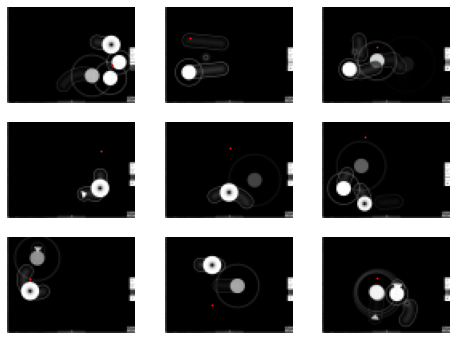

In [97]:
dls.show_batch(max_n=9, figsize=(8,6))

In [98]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

C:\Users\joshu\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\joshu\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0030199517495930195)

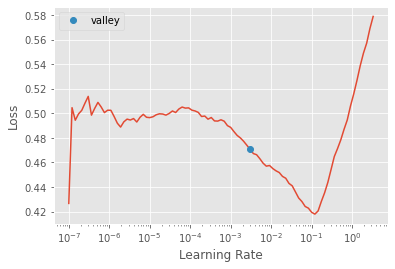

In [99]:
learn.lr_find()

In [100]:
learn.fine_tune(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.402982,0.352973,00:33


epoch,train_loss,valid_loss,time
0,0.151651,0.087414,00:50


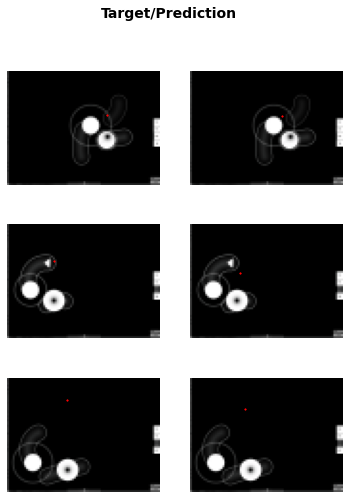

In [102]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))